In [1]:
import pandas as pd
import numpy as np
import missingno as msno
pd.set_option('display.max_rows', 500)

# **1. Data Preparation**

## **A. Read the Data**

In [2]:
jams_cimahi = pd.read_csv("Dataset/aggregate_median_jams_Kota Cimahi.csv")
# Select relevant columns
jams_cimahi = jams_cimahi[['id', 'time', 'date', 'street','median_speed_kmh', 'geometry']]
jams_cimahi.shape

(34921, 6)

In [3]:
jams_cimahi.head()

,id,time,date,street,median_speed_kmh,geometry
0,33487712,2022-07-06 00:00:00.000,2022-07-06,Tol Padaleunyi,37.080,"MULTILINESTRING ((107.534217 -6.902122, 107.53..."
1,33487711,2022-07-06 00:00:00.000,2022-07-06,Tol Padaleunyi,51.020,"LINESTRING (107.534217 -6.902122, 107.534668 -..."
2,33487713,2022-07-06 02:00:00.000,2022-07-06,Gerbang Tol Pasteur 2,7.610,"MULTILINESTRING ((107.572891 -6.889988, 107.57..."
3,33487714,2022-07-06 02:00:00.000,2022-07-06,Tol Padaleunyi,55.690,"LINESTRING (107.504788 -6.856284, 107.504752 -..."
4,33487715,2022-07-06 05:00:00.000,2022-07-06,Babakan Loa,5.605,"MULTILINESTRING ((107.565449 -6.884513, 107.56..."


In [4]:
jams_cimahi.describe()

,id,median_speed_kmh
count,3.492100e+04,34921.000000
mean,3.534541e+07,13.805416
std,1.104258e+06,7.371394
min,3.348771e+07,0.000000
25%,3.439600e+07,8.090000
50%,3.534913e+07,13.540000
75%,3.632765e+07,18.640000
max,3.729380e+07,58.530000


## **B. Add Datetime Features**

In [5]:
#Converting to datetime type
jams_cimahi["time"] = pd.to_datetime(jams_cimahi["time"])

In [25]:
print("Data timeframe is from {} to {}".format(jams_cimahi["time"].min(), jams_cimahi["time"].max()))

Data timeframe is from 2022-07-06 00:00:00 to 2022-09-06 00:00:00


In [7]:
# Adding datetime features
jams_cimahi["hour"] = jams_cimahi["time"].dt.hour
jams_cimahi["day_type"] = jams_cimahi["time"].dt.dayofweek + 1 # 1 for Monday, 7 for Sunday
jams_cimahi["day_type"] = jams_cimahi["day_type"].apply(lambda x: "Weekday" if x < 6 else "Weekend")
jams_cimahi.head()

,id,time,date,street,median_speed_kmh,geometry,hour,day_type
0,33487712,2022-07-06 00:00:00,2022-07-06,Tol Padaleunyi,37.080,"MULTILINESTRING ((107.534217 -6.902122, 107.53...",0,Weekday
1,33487711,2022-07-06 00:00:00,2022-07-06,Tol Padaleunyi,51.020,"LINESTRING (107.534217 -6.902122, 107.534668 -...",0,Weekday
2,33487713,2022-07-06 02:00:00,2022-07-06,Gerbang Tol Pasteur 2,7.610,"MULTILINESTRING ((107.572891 -6.889988, 107.57...",2,Weekday
3,33487714,2022-07-06 02:00:00,2022-07-06,Tol Padaleunyi,55.690,"LINESTRING (107.504788 -6.856284, 107.504752 -...",2,Weekday
4,33487715,2022-07-06 05:00:00,2022-07-06,Babakan Loa,5.605,"MULTILINESTRING ((107.565449 -6.884513, 107.56...",5,Weekday


In [8]:
jams_cimahi.shape

(34921, 8)

## **C. Transform Median Speed**

Here since there's possibility of important street having 'missing' median speed value because there's no recorded traffic jam during this short period data, therefore we want to impute the missing value with 0. However to do this it's logical to reciprocate median speed value (1/x) so road with better traffic speed during jam has closer value to 0

In [9]:
# Inspecting rows with median speed = 0
jams_cimahi[jams_cimahi["median_speed_kmh"] == 0]["street"].value_counts()

Batu Basal    299
Name: street, dtype: int64

It seems like Batu Basal is the only one with records of traffic speed = 0. This is because during those 2 months of recorded traffic there's a road blockage, probably due to construction. Thus we can remove Batu Basal from clustering

In [10]:
jams_cimahi = jams_cimahi[jams_cimahi["median_speed_kmh"] > 0]
jams_cimahi["median_speed_kmh"] = np.reciprocal(jams_cimahi.median_speed_kmh)

## **D. Aggregate Median Speed**

Aggregate median speed by street to create all date-time combination dimensions

In [11]:
speed_trend_df = pd.DataFrame(data=list(jams_cimahi.street.unique()), columns=["street"])

In [12]:
day_type_range = ["Weekday", "Weekend"]
hour_range = np.arange(6, 21, 1)
for day in day_type_range:
    for hour in hour_range:
        # Filter based on day type and hour
        day_hour_filter = (jams_cimahi["day_type"] == day) & (jams_cimahi["hour"] == hour)
        feature_df = jams_cimahi[day_hour_filter].groupby("street").agg({"median_speed_kmh":np.mean}).reset_index()
        feature_df.rename(columns={"median_speed_kmh":str(day)+"_"+str(hour)}, inplace=True)
        # Merge aggregated traffic speed to df
        speed_trend_df = pd.merge(speed_trend_df, feature_df, how="left")
    

In [13]:
speed_trend_df.head(3)

,street,Weekday_6,Weekday_7,Weekday_8,Weekday_9,Weekday_10,Weekday_11,Weekday_12,Weekday_13,Weekday_14,...,Weekend_11,Weekend_12,Weekend_13,Weekend_14,Weekend_15,Weekend_16,Weekend_17,Weekend_18,Weekend_19,Weekend_20
0,Tol Padaleunyi,0.055080,0.078402,0.038739,0.048435,0.021512,0.053312,0.043300,0.055688,0.054806,...,NaN,NaN,0.023510,0.036407,0.036754,0.034468,0.040988,0.043522,0.017243,0.021247
1,Gerbang Tol Pasteur 2,0.200587,0.159350,0.158442,0.133241,0.131237,0.165703,0.176877,0.153011,0.144458,...,0.178975,0.180366,0.217147,0.204521,0.177176,0.163579,0.175190,0.165679,0.188611,0.227766
2,Babakan Loa,0.513420,0.158435,0.094967,NaN,0.132303,0.133725,0.115968,0.151308,0.113407,...,0.150439,NaN,0.138964,0.122687,0.127549,0.122788,0.140517,0.137183,0.232019,NaN


In [14]:
speed_trend_df.describe()

,Weekday_6,Weekday_7,Weekday_8,Weekday_9,Weekday_10,Weekday_11,Weekday_12,Weekday_13,Weekday_14,Weekday_15,...,Weekend_11,Weekend_12,Weekend_13,Weekend_14,Weekend_15,Weekend_16,Weekend_17,Weekend_18,Weekend_19,Weekend_20
count,75.000000,85.000000,72.000000,75.000000,85.000000,84.000000,73.000000,77.000000,87.000000,86.000000,...,75.000000,76.000000,84.000000,83.000000,74.000000,83.000000,72.000000,70.000000,73.000000,59.000000
mean,0.150831,0.171677,0.129616,0.117430,0.121625,0.119350,0.117024,0.140081,0.132252,0.126853,...,0.120615,0.122137,0.139168,0.136015,0.132192,0.143189,0.120909,0.122723,0.143303,0.111089
std,0.097250,0.118311,0.072389,0.065342,0.062582,0.060741,0.061828,0.171176,0.092228,0.068310,...,0.053500,0.059079,0.109075,0.083069,0.071824,0.110181,0.079629,0.084834,0.221827,0.065365
min,0.019145,0.045126,0.036751,0.036232,0.021512,0.043403,0.038926,0.039952,0.033613,0.032379,...,0.043110,0.051125,0.023510,0.036407,0.036754,0.034468,0.038358,0.039534,0.017243,0.021247
25%,0.086275,0.095266,0.072786,0.072820,0.078249,0.077793,0.069493,0.074157,0.080158,0.080850,...,0.078796,0.082514,0.087132,0.085661,0.086364,0.080100,0.072393,0.075789,0.077111,0.065359
50%,0.119474,0.145820,0.098205,0.095924,0.106377,0.101732,0.103537,0.104742,0.103964,0.108771,...,0.106724,0.105338,0.115832,0.114548,0.110868,0.117431,0.098790,0.096717,0.105614,0.086281
75%,0.183936,0.210526,0.191663,0.129084,0.139772,0.143122,0.141243,0.156087,0.157940,0.162929,...,0.147420,0.145580,0.168069,0.155903,0.164686,0.160174,0.142223,0.140315,0.143575,0.135157
max,0.513420,0.769231,0.306770,0.349650,0.363859,0.372439,0.295686,1.515152,0.749064,0.392698,...,0.277778,0.311526,0.956938,0.550668,0.452689,0.821685,0.546257,0.530687,1.886792,0.309768


# **2. Data Cleaning**

## **A. Reducing Cardinality**

Here we'll only include the 'important' streer, which we define as those that have frequent recorded traffic jams (%observation > 1%)

In [26]:
len(jams_cimahi["street"].unique())

195

In [15]:
sel_street_df = pd.DataFrame(jams_cimahi["street"].value_counts()/len(jams_cimahi)*100).reset_index()
sel_street_df.rename(columns={"index":"street_name", "street":"perc_observation"}, inplace=True)
sel_street_df = sel_street_df[sel_street_df["perc_observation"] > 1]

In [16]:
#Filtering speed trend dataframe
speed_trend_sel = speed_trend_df[speed_trend_df["street"].isin(list(sel_street_df["street_name"].unique()))].reset_index(drop=True)
speed_trend_sel.shape

(27, 31)

<AxesSubplot:>

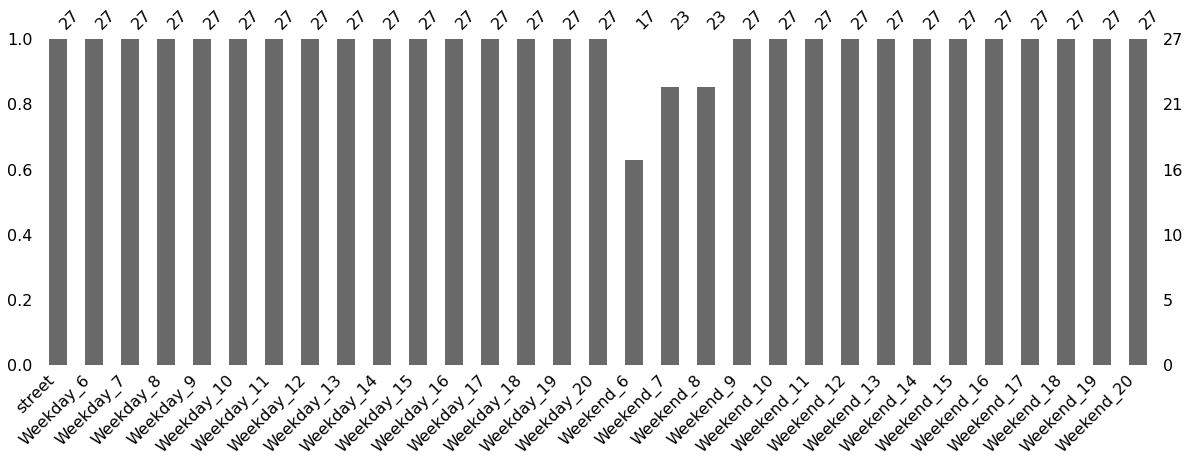

In [17]:
# Display missing value distribution
msno.bar(speed_trend_sel, figsize=(20,6))

## **B. Handling Missing Values & Data Transformation**


(array([ 92., 384., 182.,  60.,  41.,  17.,   7.,   6.,   0.,   3.]),
 array([0.01914529, 0.05850545, 0.0978656 , 0.13722576, 0.17658592,
        0.21594608, 0.25530624, 0.2946664 , 0.33402656, 0.37338672,
        0.41274688]),
 <BarContainer object of 10 artists>)

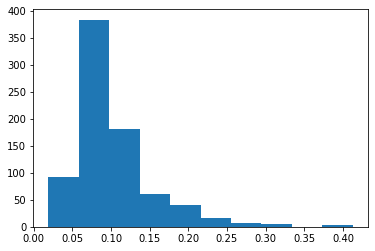

In [18]:
import matplotlib.pyplot as plt
plt.hist(np.ravel(speed_trend_sel.iloc[:,1:].values)) # The data is right-skewed

In [19]:
# Filling missing values with 0
speed_trend_sel = speed_trend_sel.fillna(0)

In [20]:
# Separating categorical and numerical columns
speed_cat = speed_trend_sel["street"]
speed_num = speed_trend_sel.iloc[:, 1:]

In [21]:
# Scaling with RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

speed_num_transformed = pd.DataFrame(scaler.fit_transform(speed_num), 
                                       columns = scaler.feature_names_in_)

In [22]:
# Combining all columns
speed_transformed = pd.concat([speed_cat, speed_num_transformed], axis=1)
speed_transformed.head()

,street,Weekday_6,Weekday_7,Weekday_8,Weekday_9,Weekday_10,Weekday_11,Weekday_12,Weekday_13,Weekday_14,...,Weekend_11,Weekend_12,Weekend_13,Weekend_14,Weekend_15,Weekend_16,Weekend_17,Weekend_18,Weekend_19,Weekend_20
0,Gerbang Tol Pasteur 2,1.416419,0.698450,1.352741,1.155874,0.841060,2.012960,2.351831,1.950483,1.057126,...,2.542126,2.661304,2.983327,3.570918,2.274561,1.709907,2.584966,1.806230,1.567344,3.380854
1,Mahar Martanegara,-0.153285,-0.448483,0.000000,-0.367276,-0.162042,0.137770,-0.104619,-0.079209,-0.214221,...,-0.426226,-0.520847,-0.320392,0.391285,0.000000,-0.051771,-0.110619,-0.166919,-0.261399,-0.052792
2,N11 Jenderal Haji Amir Machmud,-0.439469,-0.713971,-0.474020,-0.819499,-0.534403,-0.580708,-0.549800,-0.665666,-0.664644,...,-0.935676,-1.057801,-0.979060,-1.103045,-0.837536,-0.878052,-0.710628,-0.619284,-0.091564,-0.157548
3,Jalan Gunung Batu,0.000000,0.403608,0.518056,0.001542,-0.150609,-0.008174,0.000000,0.212351,0.009109,...,0.094236,0.148003,0.014723,-0.172563,-0.051600,0.000000,-0.033502,-0.313475,-0.365763,-0.214854
4,Jenderal Gatot Subroto,0.129219,0.071971,0.427803,0.231585,1.554622,0.658961,0.084063,1.132302,0.238147,...,0.313228,0.798610,0.307703,0.522826,0.605517,0.495725,-0.009948,0.201655,0.875481,-0.359155


In [23]:
# Exporting clean dataset (without scaling)
# speed_trend_sel.to_csv("Dataset_cleaned/agg_jams_speed_Kota_Cimahi_plotting.csv",index = False)

In [24]:
# Exporting clean dataset (with scaling)
# speed_transformed.to_csv("Dataset_cleaned/agg_jams_speed_Kota_Cimahi_clustering.csv",index = False)